In [1]:
# Required packages
import pandas as pd
import numpy as np
import geopandas as gpd
import json
import os

# Visualisation libraries

## Text
from colorama import Fore, Back, Style
from IPython.display import Image, display, Markdown, Latex, clear_output
import progressbar

# Maps
import geoplot as gplt
import geoplot.crs as gcrs
import mplleaflet
from shapely.geometry import Point, Polygon


# Maps
import folium
from folium import plugins
from folium.plugins import HeatMap

## seaborn
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper", rc={"font.size":12,"axes.titlesize":14,"axes.labelsize":12})


## matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Polygon
import matplotlib.gridspec as gridspec
import matplotlib.colors
from pylab import rcParams
plt.style.use('seaborn-whitegrid')
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (17, 6)
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

<div class="alert alert-block alert-success">
<font size="+2"><b>
Calgary Property Assessments
</b></font>
</div>

The assessed values of residential, non-residential, and farmland properties in Calgary. The properties in this dataset consist of Calgary lands that have a registered parcel at Alberta’s Land Titles Office.  Properties that are on The City of Calgary’s annual property assessment rolls, but excluded from this dataset, are titled parking stalls, titled storage units, machinery & equipment property, and linear property (as defined in the Municipal Government Act). This dataset can be downloaded from [here](https://data.calgary.ca/dataset/Property-Assessments/6zp6-pxei).

For detailed property assessment information, visit https://assessmentsearch.calgary.ca


| Column Name                  | Description                                 | Type       |
|------------------------------|---------------------------------------------|------------|
| ROLL_YEAR                    | Assessment roll year                        | Number     |
| ROLL_NUMBER                  | Assessment account roll number              | Plain Text |
| ADDRESS                      | Civic address                               | Plain Text |
| ASSESSED_VALUE               | Total assessed value of the property        | Number     |
| ASSESSMENT_CLASS             | Predominant assessment class code           | Plain Text |
| ASSESSMENT_CLASS_DESCRIPTION | Description of predominant assessment class | Plain Text |
| RE_ASSESSED_VALUE            | Assessed value of residential property      | Number     |
| NR_ASSESSED_VALUE            | Assessed value of non-residential property  | Number     |
| FL_ASSESSED_VALUE            | Assessed value of farmland                  | Number     |
| COMM_CODE                    | Community code                              | Plain Text |
| COMM_NAME                    | Community name                              | Plain Text |
| LATITUDE                     | Latitude                                    | Number     |
| LONGITUDE                    | Longitude                                   | Number     |
| location                     |                                             | Location   |
| UNIQUE_KEY                   |                                             | Plain Text |
| YEAR_OF_CONSTRUCTION         |                                             | Number     |

#### Table of contents

* [Property Assessments](#Property-Assessments)
* [Datasets](#Datasets)
* [Data Analysis](#Data-Analysis)
    * [Average Value (the Current Year)](#Average-Price-(the-Current-Year))
        * [Average Value (Non-residential)](#Average-Price-(Non-residential))
        * [Average Value (Residential)](#Average-Price-(Residential))
        * [Average Value (Farmland)](#Average-Price-(Farmland))
        * [Average Value (Machinery And Equipment)](#Average-Price-(Machinery-And-Equipment))
        * [Assessed Average Value by Sector](#Assessed-Average-Value-by-Sector)
        * [Assessed Average Value by Community Structure](#Assessed-Average-Value-by-Community-Structure)
    * [Maps](#Maps)
        * [Assessed Average Value by Community](#Assessed-Average-Value-by-Community)
        * [Asset Values in Each Community](#Asset-Values-in-Each-Community)
* [Predictions](#Predictions)

# Datasets

In [2]:
Path = 'Calgary/Property_Assessments_mod.csv'
Data = pd.read_csv(Path)
Temp = os.stat(Path).st_size/(1024 **3)
print('File Size in GigaBytes is %1.2f' % Temp)
del Path, Temp
clear_output()
display(Data.head(4).style.hide_index())

We can also use the community boundaries for the city of Calgary from [here](https://data.calgary.ca/Base-Maps/Community-Boundaries/ab7m-fwn6).

In [3]:
Community_Boundaries = gpd.read_file('Calgary/Community_Boundaries.geojson')
# Chaning the headers to title
mylist = Community_Boundaries.columns.tolist()
mylist = [x.title() for x in mylist]
mylist = [x.replace('Geometry','geometry') for x in mylist]
Community_Boundaries.columns = mylist
del mylist
display(Community_Boundaries.head(4))

Comm_Structure          Name     Sector Class_Code         Srg  \
0     INNER CITY       SUNALTA     CENTRE          1   BUILT-OUT   
1   BUILDING OUT  WEST SPRINGS       WEST          1  DEVELOPING   
2          OTHER           12A  SOUTHEAST          4         N/A   
3          1950s  WINDSOR PARK     CENTRE          1   BUILT-OUT   

               Class Comm_Code  \
0        Residential       SNA   
1        Residential       WSP   
2  Residual Sub Area       12A   
3        Residential       WND   

                                            geometry  
0  POLYGON ((-114.10061 51.04799, -114.10056 51.0...  
1  POLYGON ((-114.18781 51.06151, -114.18781 51.0...  
2  POLYGON ((-113.86945 50.97957, -113.86945 50.9...  
3  POLYGON ((-114.08152 51.00872, -114.08137 51.0...

<div class="alert alert-block alert-info">
<font size="+2"><b>
Exploratory Data Analysis
</b></font>
</div>

First, of all the dataset includes the following assessment roll years.

In [4]:
Years = np.sort(Data.Roll_Year.unique())
Years.min(), Years.max()

(2005, 2020)

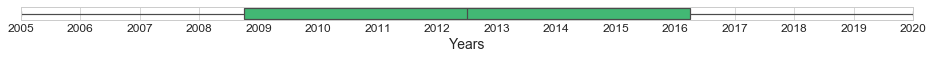

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 0.25), sharex=False)
_ = sns.boxplot(x=Years, ax=ax, orient='h', color='#2ecc71')
_ = ax.set_xlabel('Years')
_ = ax.set_xlim([Years.min(), Years.max()])
_ = ax.set_xticks(Years)
_ = ax.grid('off')

In particular, in each year:

Roll_Year    2005    2006    2007    2008    2009    2010    2011    2012  \
Count      361362  376124  388977  406818  424240  431813  441823  448080   

Roll_Year    2013    2014    2015    2016    2017    2018    2019    2020  
Count      460129  468200  478339  493405  505988  525865  537137  545230

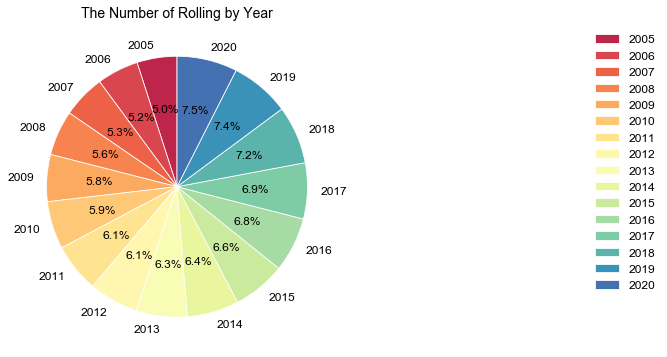

In [6]:
Group = pd.DataFrame(Data.groupby('Roll_Year')['Unique_Key'].count())
Group.columns = ['Count']
display(Group.T)

fig, ax = plt.subplots(1,1, figsize=(6,6))
_ = Group.plot.pie(y='Count', startangle=90, legend=False,label='',ax=ax, autopct='%1.1f%%',
                   colors = sns.color_palette("Spectral", len(Group)), fontsize=12)
_ = ax.legend(bbox_to_anchor=(2, 1), fontsize = 12)
_ = ax.set_title('The Number of Rolling by Year')

The following functions will be used throughout this article.

In [7]:
def address_map(Inp, Zoom=12.5, Icon='info-sign'):
    m = folium.Map(location=[Temp.Latitude[0], Temp.Longitude[0]], zoom_start=Zoom)
    folium.Marker(location=[Temp.Latitude[0], Temp.Longitude[0]],popup = Temp.Address[0],
                  icon=folium.Icon(icon=Icon)).add_to(m)
    display(m)
    return 

def Roll_Number_Data (Roll_Number):
    Out = Data[Data.Roll_Number == Roll_Number].sort_values(by='Roll_Year',
                                                                ascending=True).reset_index(drop =True)
    return Out

def Roll_Number_Table(Inp):
    Out = Inp[['Roll_Year','Assessed_Value','Assessment_Class_Description']]
    Out = Out.rename(columns={'Roll_Year':'Year','Assessed_Value':'Value','Assessment_Class_Description':'Class'})
    Out = Out.set_index('Year')
    Out = Out.T
    return Out 

def Unit_Price(Inp):
    fig, ax = plt.subplots(figsize=(14,5))
    fig = sns.regplot(x='Roll_Year', y='Assessed_Value', data=Inp, color='#e74c3c',
                      scatter_kws={'s': 50, 'color': '#34495e'},order=10, ci=None, truncate=False)
    _ = ax.set_title('The Price Fluctuations for %s Unit at %s (%s)' % (Inp.Assessment_Class_Description.tolist()[-1],
                                                                        Inp.Address.tolist()[-1],
                                                                       Inp.Comm_Name.unique()[0]))
    _ = ax.set_ylabel('Assessed')
    _ = ax.set_xlabel('Price')
    _ = ax.set_xticks(np.arange(Inp.Roll_Year.min(),Inp.Roll_Year.max()+1,1)) 

Consider the assessed values only in the current year:

In [8]:
Current_year = Data[Data['Roll_Year']==Data['Roll_Year'].max()]

The most expensive venue currently is

In [9]:
Temp = Current_year[Current_year.Assessed_Value ==Current_year.Assessed_Value.max()].dropna(axis=1)
Temp

Roll_Year  Roll_Number           Address  Assessed_Value  \
6661341       2020    201443785  4448 FRONT ST SE    1.492130e+09   

        Assessment_Class Assessment_Class_Description  Nr_Assessed_Value  \
6661341               NR              Non-residential       1.492130e+09   

        Comm_Code Comm_Name   Latitude   Longitude  \
6661341       SET     Seton  50.882258 -113.952634   

                                          Location     Unique_Key  \
6661341  (50.882257605632304, -113.95263363033702)  2020201443785   

         Year_Of_Construction Comm_Structure     Sector  Class_Code  \
6661341                2007.0   Building Out  Southeast           1   

                Srg        Class  
6661341  Developing  Residential

For this unit, we have

Year              2010             2011             2012             2013  \
Value          3.5e+06         5.61e+06         6.55e+06         6.55e+06   
Class  Non-residential  Non-residential  Non-residential  Non-residential   

Year              2014             2015             2016             2017  \
Value       7.4584e+08       9.3332e+08       9.3008e+08        9.324e+08   
Class  Non-residential  Non-residential  Non-residential  Non-residential   

Year              2018             2019             2020  
Value      1.44933e+09      1.48217e+09      1.49213e+09  
Class  Non-residential  Non-residential  Non-residential

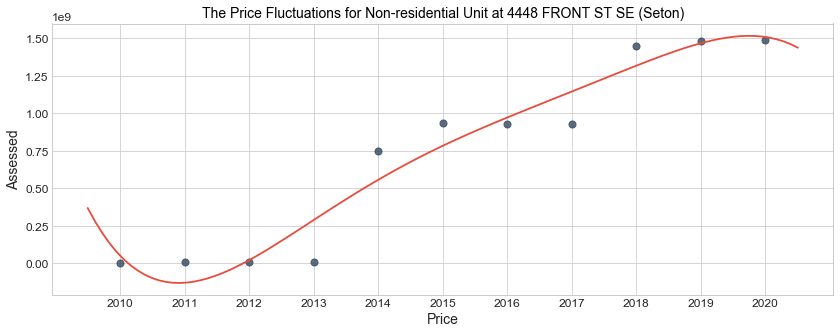

In [10]:
Temp = Roll_Number_Data(Temp.Roll_Number.values[0])
display(Roll_Number_Table(Temp))
Unit_Price(Temp)

In [11]:
address_map(Temp, 14.5)

In [12]:
print('As can be seen the unit is a %s unit, and it is located in %s.' % (Temp.Assessment_Class_Description.tolist()[-1],
                                                                         Temp.Comm_Name.unique()[0])) 

As can be seen the unit is a Non-residential unit, and it is located in Seton.


## Average Value (the Current Year)

The following function can be used for calculating the Average Value of each community.

In [13]:
def Community_Ave_yr(Yr=2020, Sort = True, Inp=Data, Boundaries = Community_Boundaries):
    Temp = Inp[Inp['Roll_Year']==Yr]
    Temp1 = Temp.groupby(['Comm_Code', 'Comm_Name', 'Assessment_Class_Description',
                          'Comm_Structure', 'Sector'])['Assessed_Value'].agg({'mean','median', 'max', 'min'})
    Temp1 = Temp1.rename(columns = {'mean':'Average Value', 'median':'Median Value',
                                    'max':'Maximum Value', 'min':'Minimum Value'})
    Temp1 = Temp1.reset_index()
    Out = Temp1.merge(Boundaries [['Comm_Code', 'geometry']], how='right', on='Comm_Code')
    del Temp, Temp1
    Out = Out[pd.notnull(Out['Average Value'])]
    if Sort:
        Out = Out.sort_values(by='Average Value', ascending=False)
    return Out 

In [14]:
Community_Ave = Community_Ave_yr(Sort = True)
Community_Ave.iloc[:,:-1].head(15).style.format({'Maximum Value': "{:.2e}", 'Minimum Value': "{:.2e}",
                                                      'Median Value': "{:.2e}", 'Average Value': "{:.2e}"}).hide_index().\
                                                    background_gradient(subset= ['Average Value'], cmap='GnBu')

### Average Value (Non-residential)

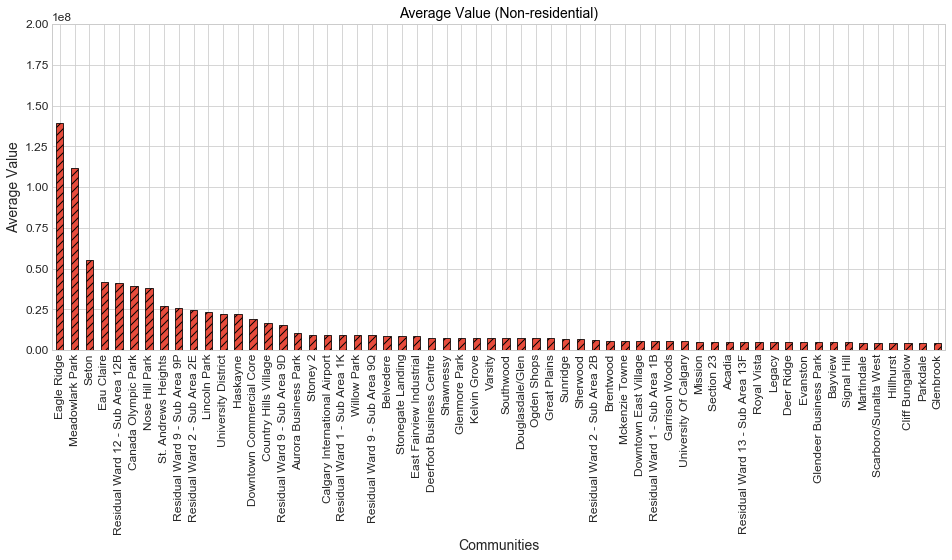

In [15]:
def UpBound(x):
    x = x.max()
    n = len(str(int(x))) -1
    x = np.ceil(x/(10**n))*(10**n)
    return int(x)

Class = 'Non-residential'
Temp = Community_Ave[Community_Ave.Assessment_Class_Description == Class][['Comm_Name','Average Value']]
if len(Temp)>60:
    Temp = Temp.head(60)
# Figure
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 6), sharex=False)
Temp.head(90).plot.bar(x='Comm_Name', y='Average Value', rot=90,ax=ax, legend=False,
                       color='#e74c3c', edgecolor='k', hatch ='///')
_ = ax.set_title('Average Value (%s)' % Class)
_ = ax.set_ylabel('Average Value')
_ = ax.set_xlabel('Communities')
_ = ax.set_ylim([0, UpBound(Temp['Average Value'])])

### Average Value (Residential)

Moreover, for residential, we have,

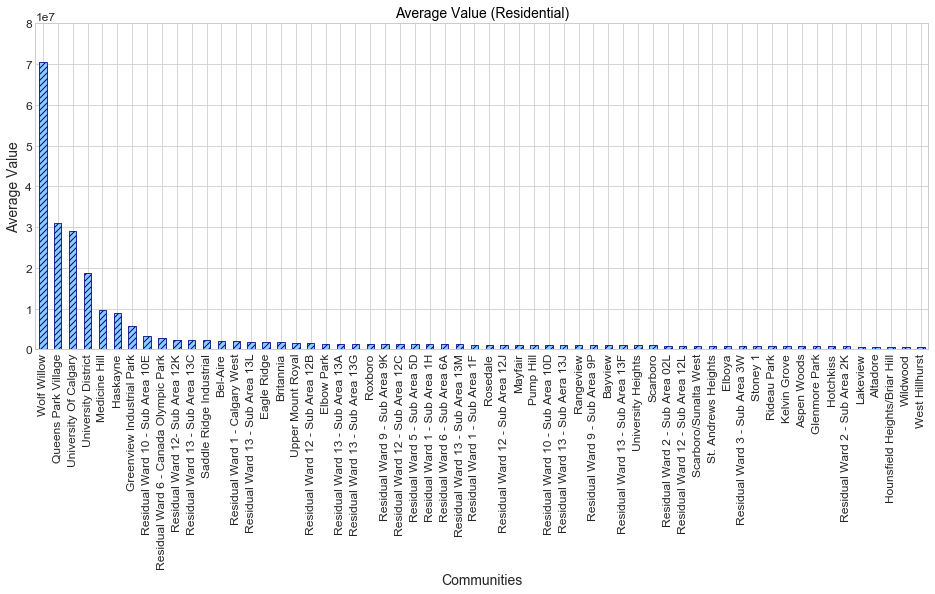

In [16]:
Class = 'Residential'
Temp = Community_Ave[Community_Ave.Assessment_Class_Description == Class][['Comm_Name','Average Value']]
if len(Temp)>60:
    Temp = Temp.head(60)
# Figure
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 6), sharex=False)
Temp.head(90).plot.bar(x='Comm_Name', y='Average Value', rot=90,ax=ax, legend=False,
                       color='lightskyblue', edgecolor='navy', hatch = '////')
_ = ax.set_title('Average Value (%s)' % Class)
_ = ax.set_ylabel('Average Value')
_ = ax.set_xlabel('Communities')
_ = ax.set_ylim([0, UpBound(Temp['Average Value'])])

### Average Value (Farmland)

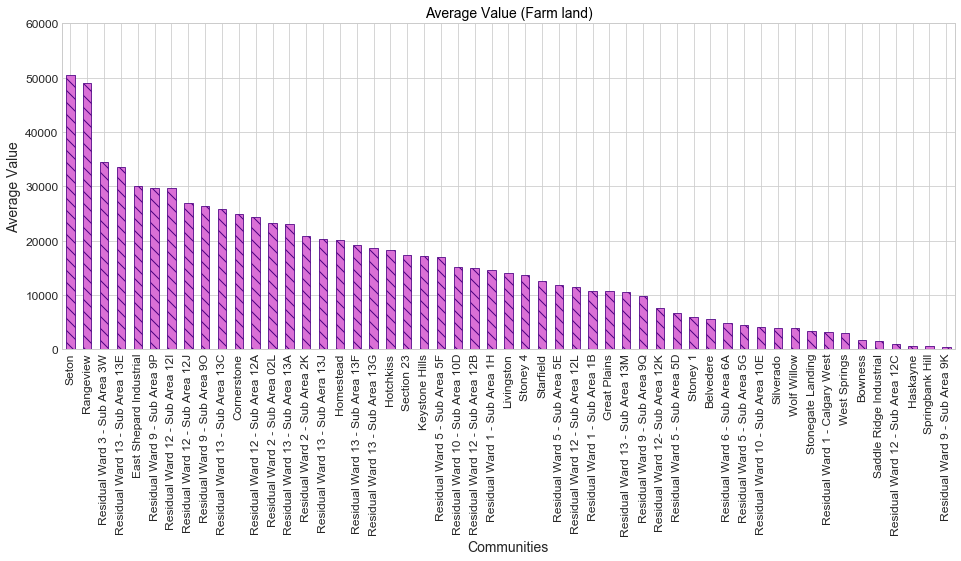

In [17]:
Class = 'Farm land'
Temp = Community_Ave[Community_Ave.Assessment_Class_Description == Class][['Comm_Name','Average Value']]
if len(Temp)>60:
    Temp = Temp.head(60)
# Figure
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 6), sharex=False)
Temp.head(90).plot.bar(x='Comm_Name', y='Average Value', rot=90,ax=ax, legend=False,
                       color='orchid', edgecolor='indigo', hatch = '\\\\')
_ = ax.set_title('Average Value (%s)' % Class)
_ = ax.set_ylabel('Average Value')
_ = ax.set_xlabel('Communities')
_ = ax.set_ylim([0, UpBound(Temp['Average Value'])])

### Average Value (Machinery And Equipment)

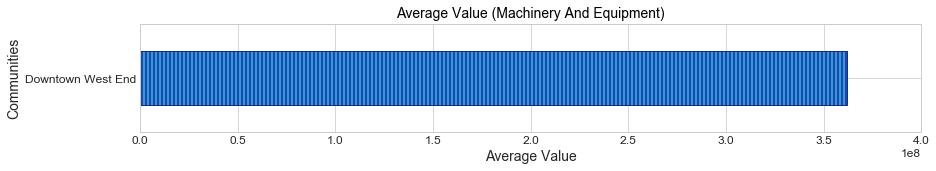

In [18]:
Class = 'Machinery And Equipment'
Temp = Community_Ave[Community_Ave.Assessment_Class_Description == Class][['Comm_Name','Average Value']]
if len(Temp)>60:
    Temp = Temp.head(60)
# Figure
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 2), sharex=False)
Temp.head(90).plot.barh(x='Comm_Name', y='Average Value', rot=0,ax=ax, legend=False ,color='#3498db',
                        edgecolor='Navy', hatch = '|||')
_ = ax.set_title('Average Value (%s)' % Class)
_ = ax.set_xlabel('Average Value')
_ = ax.set_ylabel('Communities')
_ = ax.set_xlim([0,4e8])

### Assessed Average Value by Sector

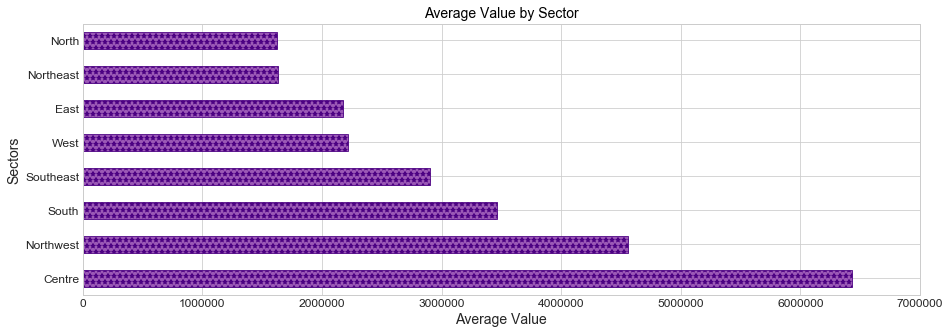

In [19]:
Temp = pd.DataFrame(Community_Ave.groupby(['Sector'])['Average Value'].mean()).reset_index()
Temp = Temp.sort_values(by='Average Value', ascending=False)
# Figure
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5), sharex=False)
Temp.head(90).plot.barh(x='Sector', y='Average Value', rot=0,ax=ax, legend=False,
                        color='#9b59b6', edgecolor='indigo', hatch = '**')
_ = ax.set_title('Average Value by Sector')
_ = ax.set_xlabel('Average Value')
_ = ax.set_ylabel('Sectors')
_ = ax.set_xlim([0, UpBound(Temp['Average Value'])])

### Assessed Average Value by Community Structure

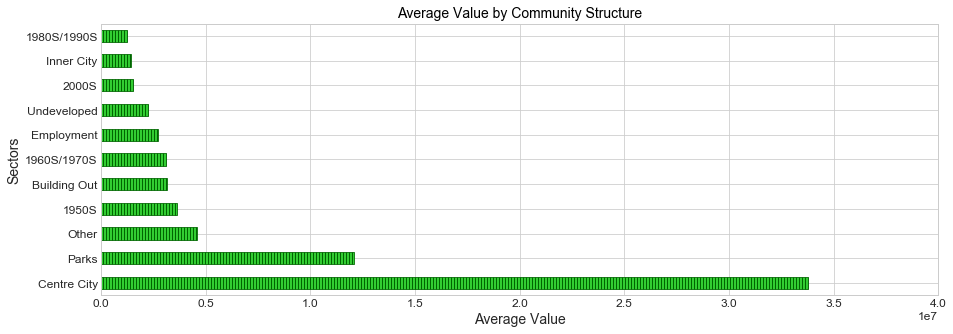

In [20]:
Temp = pd.DataFrame(Community_Ave.groupby(['Comm_Structure'])['Average Value'].mean()).reset_index()
Temp = Temp.sort_values(by='Average Value', ascending=False)
# Figure
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5), sharex=False)
Temp.head(90).plot.barh(x='Comm_Structure', y='Average Value', rot=0,ax=ax, legend=False,
                        color='limegreen', edgecolor='DarkGreen', hatch = '||||')
_ = ax.set_title('Average Value by Community Structure')
_ = ax.set_xlabel('Average Value')
_ = ax.set_ylabel('Sectors')
_ = ax.set_xlim([0, UpBound(Temp['Average Value'])])

# Maps

### Assessed Average Value by Community

In [21]:
def Community_Ave_yr(Yr, Inp=Data):
    Temp = Data[Data['Roll_Year']==Yr]
    Out = pd.DataFrame(Temp.groupby('Comm_Code')['Assessed_Value'].mean())
    Out.columns =['Average Value']
    Out = Out.reset_index()
    del Temp
    Temp = pd.merge(Community_Boundaries, Out, how ='inner', on ='Comm_Code')
    Out = Temp.copy()
    del Temp
    Out = Out[['Average Value', 'geometry']]
    return Out 

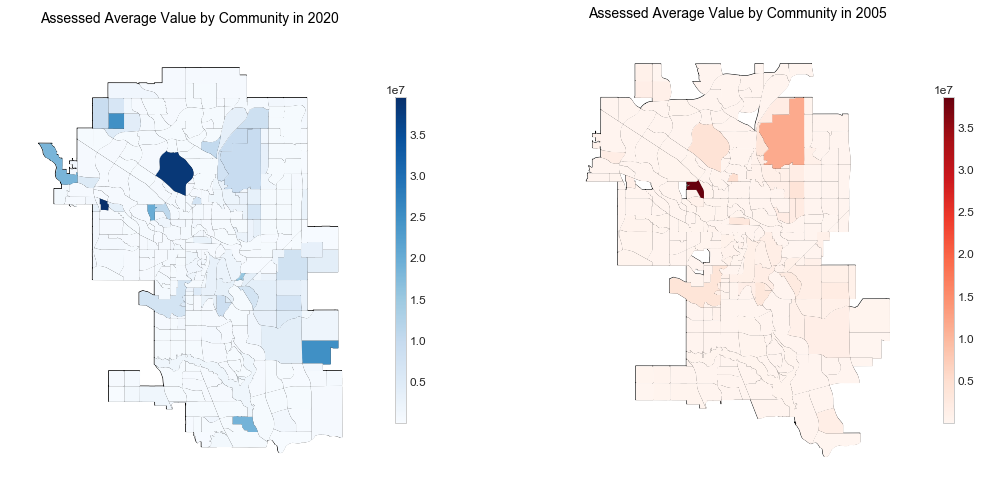

In [22]:
proj = gcrs.AlbersEqualArea(central_latitude = Data.Latitude.mean(), central_longitude = Data.Longitude.mean())
f, ax = plt.subplots(1, 2, figsize=(18, 12), subplot_kw={'projection': proj})

# Left Plot
Temp = Community_Ave_yr(Data.Roll_Year.max())
_ = gplt.choropleth(Temp, hue = 'Average Value', cmap='Blues', linewidth=0.0, ax = ax[0], legend=True,
                    legend_kwargs={'shrink': .5, "aspect":30})
_ = gplt.polyplot(Temp, edgecolor='black', linewidth=0.8, ax = ax[0])
_ = ax[0].set_title('Assessed Average Value by Community in %i'% Data.Roll_Year.max())
del Temp

# Right Plot
Temp = Community_Ave_yr(Data.Roll_Year.min())
_ = gplt.choropleth(Temp, hue = 'Average Value', cmap='Reds', linewidth=0.0, ax = ax[1], legend=True,
                    legend_kwargs={'shrink': .5, "aspect":30})
_ = gplt.polyplot(Temp, edgecolor='black', linewidth=0.6, ax = ax[1])
_ = ax[1].set_title('Assessed Average Value by Community in %i' % Data.Roll_Year.min())
del Temp 

### Asset Values in Each Community

We can define the following heatmap to show the Assessed values in each community. In each case, the to fifty most values asses are also marked on the map.

In [23]:
def map_points(df, Zoom = 13, TOP = 10, heat_map_weights_col='Assessed_Value', Normalize=False, heat_map_radius=10):
    
    M = folium.Map(location=[df['Latitude'].median(), df['Longitude'].median()], zoom_start = Zoom)
    if heat_map_weights_col is None:
        Cols = ['Latitude', 'Longitude']
    else:
        if Normalize:
            df[heat_map_weights_col] = df[heat_map_weights_col] / df[heat_map_weights_col].sum()
        Cols = ['Latitude', 'Longitude', heat_map_weights_col]
    
    M.add_child(plugins.HeatMap(df[Cols].values, radius=heat_map_radius))
    
    Tops = df.head(TOP)
    for i in range(len(Tops)):
        Inp=df[i:(i+1)]
        St = '(Value:' + str(Inp.Assessed_Value.values[0])+', Class:' + Inp.Assessment_Class_Description.values[0] + ')'
        if (Inp.Assessment_Class.values[0] == 'RE'):
            folium.Marker(location=[Inp.Latitude.values[0], Inp.Longitude.values[0]], popup = St,
                          icon=folium.Icon(color='purple',icon='building', prefix='fa') ).add_to(M)
        else:
            folium.Marker(location=[Inp.Latitude.values[0], Inp.Longitude.values[0]], popup = St).add_to(M)
            
    display(M)

For example, consider the **Seton** community.

In [24]:
Temp = Data[Data.Roll_Year == Data.Roll_Year.max()]
Temp = Temp[Temp.Comm_Name == 'Seton']
map_points(Temp, 14, 50)

Similarly, for the **Brentwood** community, we have,

In [25]:
Temp = Data[Data.Roll_Year == Data.Roll_Year.max()]
Temp = Temp[Temp.Comm_Name == 'Brentwood']
map_points(Temp, 13.5, 50)

# Predictions

Unfortunately, the given data are not suitable for any forms of predictions since we mainly know the location of an asset,  and their classes and values. Hopefully, in the future, this study can be extended.

***